# Report from experimental fine-tuning with zpp-murmuras/llama-ds-big_dm dataset
## Output Data Format
As our OpenAPI credits are exhausted we have decided to simplify target data format to enable automated generation of examples.

Now the coupon is represented by following JSON:
```json
{
  "discount_text": "text",
  "product_name": "name",
  "valid_unitl": "validity"
}
```
Where the `discount_text` field is a general field that is filled with the new price, the percentage of the discount or other.

As this change is yet to be consulted with Murmuras, the format might be a subject of future changes.
## Memory issues
It was impossible for me to run the training properly on this dataset without lowering the `per_device_train_batch_size` param from 16 to 8. Additionally, as I had increased the `gradient_accumulation_steps` to 16 from 8, I had to lower batch size further to 4. That suggests that root cause here is related to memory shortage. This is unexpected as metrics on modal showed GPU RAM usage around 4GB, which is afaik way lower than H100 GPU total RAM.
## Hyperparameters
### optimizers
Results of mine finetunings as well as those from [PR #79](https://github.com/ZPP-MURMURAS/ZPP_Murmuras/pull/79) indicate that after first few epochs loss explodes and never reaches initial level. I have observed this anomaly when fine-tuning with optimizer from adam family or rmsprop. SGD on the other hand has no problem with it. Usually this phenomenon is observed with a gradient explosion.

I have tried lowering lr, playing with adam params, clipping the gradient, lowering the weight decay rate, changing gradient accumulation steps and running with different lr schedulers, but with little result. My experiments were far from being exhaustive, but at this moment I recommend using SGD.
### lr schedulers
From my experience the `constant` scheduler outperforms other ones for 30 epochs. This probably will change if we will run the training with a greater number of epochs.
## Costs
The experiments performed costed me around $13 in Modal credits. As I performed more than 15 runs, each consisting of 30 epochs, the training costs were lower than our original estimations.

In [7]:
import wandb
import matplotlib.pyplot as plt

In [9]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/szymon/.netrc
wandb: Currently logged in as: sf-kozlowski (sf-kozlowski-university-of-warsaw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [23]:
PROJECT_NAME = 'llama-finetune-dm'
CONST_LR_COMP = [
    'lion_8bit, constant lr',
    'adamw_8bit, constant lr',
    'rmsprop, constant lr',
    'sgd, constant lr'
]
ADAMW_ATTEMPTS = [
    'adam2_8bit, constant_with_warmup lr clip=0.1 decay=0.001',
    'adamw_8bit, constant lr, gradient clipping',
    'adamw_8bit, constant lr',
    'adamw_8bit, constant_with_warmup lr',
    'adamw_8bit, cosine lr'
]
SGD_ATTEMPTS = [
    'sgd, constant lr',
    'sgd, cosine lr'
]
COMPARISONS = {
    'Constant Learning Rate, different optimizers': CONST_LR_COMP,
    'AdamW optimizer experiments': ADAMW_ATTEMPTS,
    'SGD optimizer experiments': SGD_ATTEMPTS
}


In [16]:
# credits to GustawB
def plot_runs_data(runs, metric, runs_active, log_scale=False):
    plt.figure(figsize=(10, 5))
    if log_scale:
        plt.yscale('log')
    for run in runs:
        if run.name in runs_active:
            history = run.history()
            plt.plot(history["_step"], history[metric], label=f"Run: {run.name}")

    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.title(f"{metric} across Runs")
    plt.legend()
    plt.grid()
    plt.show()
api = wandb.Api()
runs = api.runs(f"{wandb.Api().default_entity}/{PROJECT_NAME}")

# Metrics Comp for different optimizers with constant learning rate scheduler

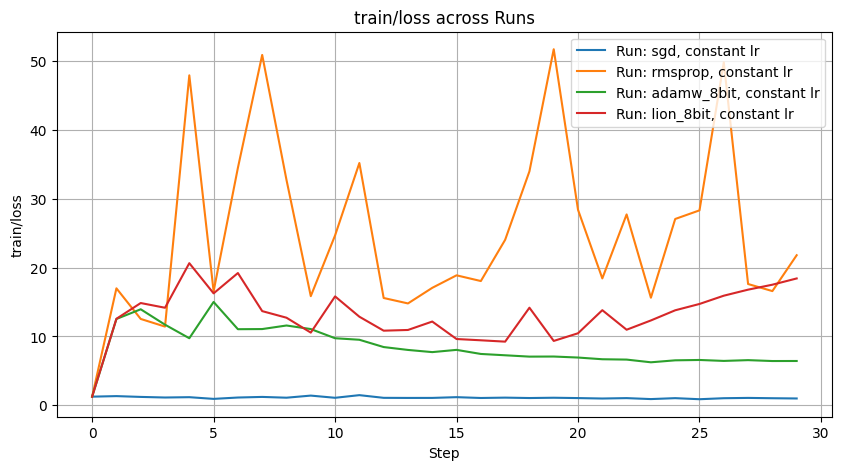

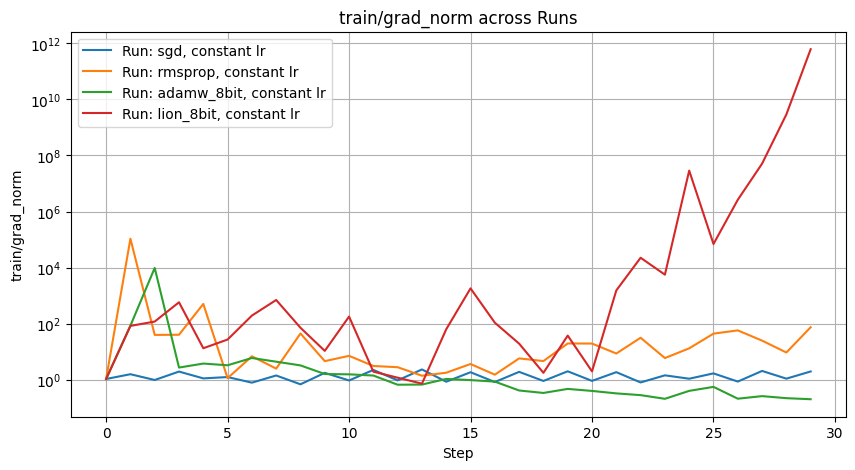

In [17]:
plot_runs_data(runs, 'train/loss', runs_active=COMPARISONS["Constant Learning Rate, different optimizers"])
plot_runs_data(runs, 'train/grad_norm', runs_active=COMPARISONS["Constant Learning Rate, different optimizers"], log_scale=True)

# Metrics Comp for experiments with AdamW

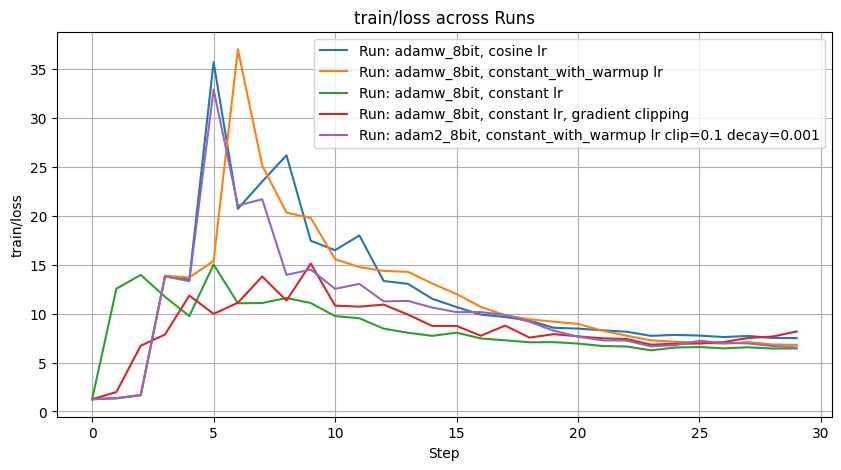

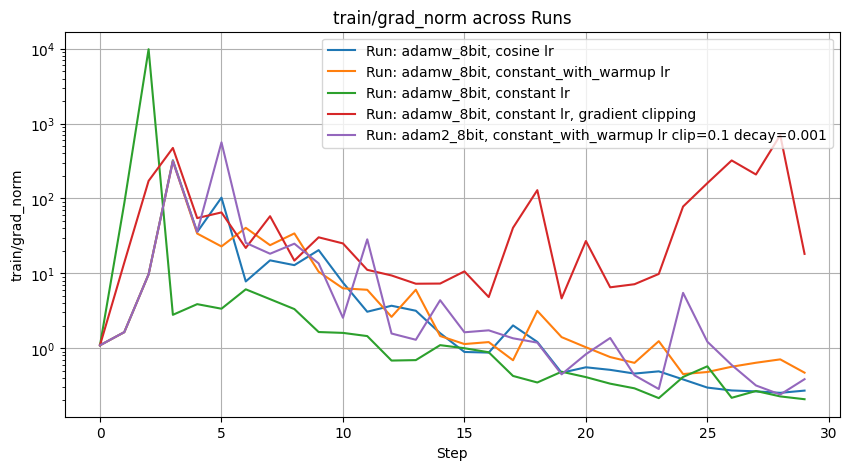

In [18]:
plot_runs_data(runs, 'train/loss', runs_active=COMPARISONS["AdamW optimizer experiments"])
plot_runs_data(runs, 'train/grad_norm', runs_active=COMPARISONS["AdamW optimizer experiments"], log_scale=True)

# Metrics Comp for experiments with SGD

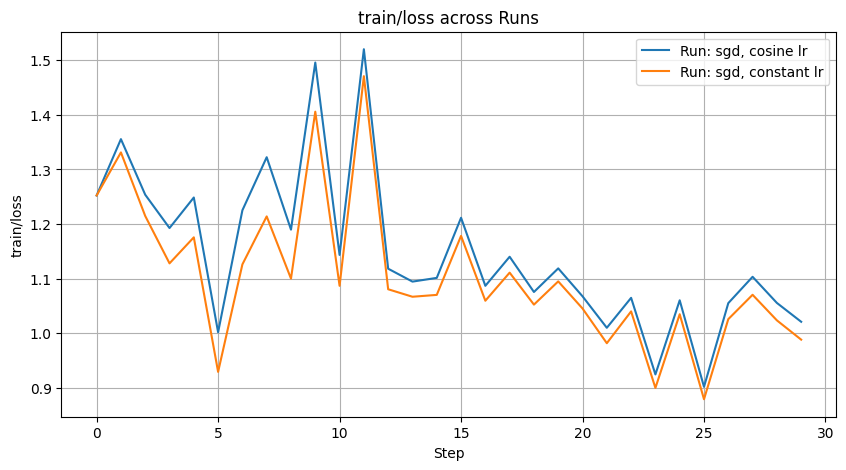

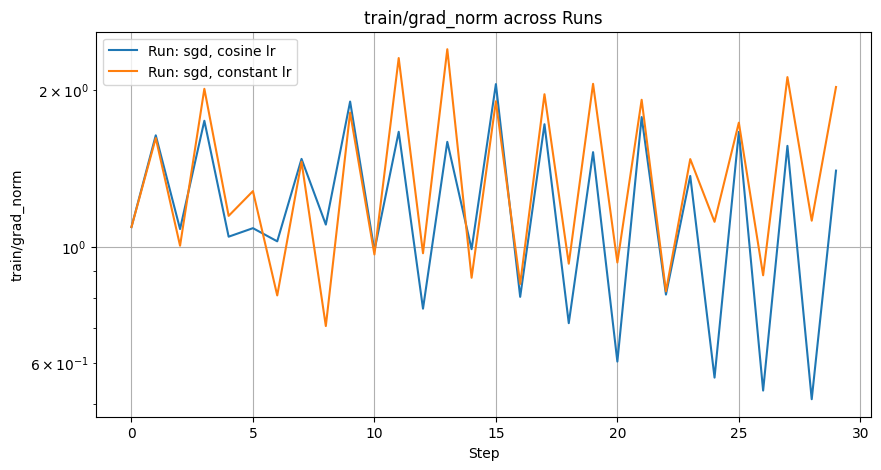

In [24]:
plot_runs_data(runs, 'train/loss', runs_active=COMPARISONS["SGD optimizer experiments"])
plot_runs_data(runs, 'train/grad_norm', runs_active=COMPARISONS["SGD optimizer experiments"], log_scale=True)